## Bilocal Noise Robustness Analysis

This notebook investigates the effect of noise on quantum violations to the bilocal inequality.
Noise is applied to the qubits generated at each source.
A different noise parameter is used for the qubits of each source.
This models two entanglement sources with similar noise models, but different amounts of noise.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


from context import qnetvo as QNopt

In [2]:
def trace_distance(A, B):
    return np.sum([np.abs(eig_val) for eig_val in linalg.svd(A - B, hermitian=True)[1]])/2

In [3]:
def RY_CNOT(settings, wires):
    qml.RY(settings[0], wires=wires[0])
    qml.RY(settings[1], wires=wires[1])
    qml.CNOT(wires=wires[0:2])

bell_prep_nodes = [
    QNopt.PrepareNode(1, [0, 1], RY_CNOT, 2),
    QNopt.PrepareNode(1, [2, 3], RY_CNOT, 2),
]
arb_prep_nodes = [
    QNopt.PrepareNode(1, [0, 1], qml.templates.subroutines.ArbitraryUnitary, 15),
    QNopt.PrepareNode(1, [2, 3], qml.templates.subroutines.ArbitraryUnitary, 15)
]

RY_meas_nodes = [
    QNopt.MeasureNode(2, 2, [0], QNopt.local_RY, 1),
    QNopt.MeasureNode(2, 2, [1,2], QNopt.local_RY, 2),
    QNopt.MeasureNode(2, 2, [3], QNopt.local_RY, 1),
]

arb_meas_nodes = [
    QNopt.MeasureNode(2, 2, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.MeasureNode(2, 2, [1,2], qml.templates.subroutines.ArbitraryUnitary, 15),
    QNopt.MeasureNode(2, 2, [3], qml.templates.subroutines.ArbitraryUnitary, 3)
]

## Main Function for Scanning Through Channel Parameters

In [10]:
params_range = a = np.append(np.arange(0,1,0.1),[0.99999])
params_range.requires_grad=False

def scan_channel_robustness(prep_nodes, meas_nodes, qubit_channels, scan_range):
    
    opt_violations = np.zeros((11,11))
    noiseless_violations = np.zeros((11,11))
    
    depolarized_distances = np.zeros((11,11))
    noiseless_depolarized_distances = np.zeros((11,11))
    
    classical_distances = np.zeros((11,11))
    noiseless_classical_distances = np.zeros((11,11))
    
    p1_scan_params, p2_scan_params = np.meshgrid(scan_range,scan_range)

    
    ideal_bilocal_ansatz = QNopt.NetworkAnsatz(prep_nodes, meas_nodes)
    noiseless_bilocal_cost = QNopt.nlocal_chain_cost_22(ideal_bilocal_ansatz)        
    for i in range(len(scan_range)):
        for j in range(len(scan_range)):
            chan_params = [
                p1_scan_params[i,j], p1_scan_params[i,j],
                p2_scan_params[i,j], p2_scan_params[i,j]
            ]
            
            print("Channel Parameters : ", chan_params)
                
            noise_nodes = [
                QNopt.NoiseNode([0], lambda settings, wires: qubit_channels[0](chan_params[0], wires=wires[0])),
                QNopt.NoiseNode([1], lambda settings, wires: qubit_channels[0](chan_params[1], wires=wires[0])),
                QNopt.NoiseNode([2], lambda settings, wires: qubit_channels[1](chan_params[2], wires=wires[0])),
                QNopt.NoiseNode([3], lambda settings, wires: qubit_channels[1](chan_params[3], wires=wires[0]))
            ]

            noisy_bilocal_ansatz = QNopt.NetworkAnsatz(prep_nodes, meas_nodes, noise_nodes)

            @qml.qnode(noisy_bilocal_ansatz.dev)
            def noisy_state(prep_settings):
                noisy_bilocal_ansatz.circuit_layer(noisy_bilocal_ansatz.prepare_nodes)(prep_settings)
                noisy_bilocal_ansatz.circuit_layer(noisy_bilocal_ansatz.noise_nodes)(chan_params)

                return qml.state()

            @qml.qnode(noisy_bilocal_ansatz.dev)
            def noiseless_state(prep_settings):
                ideal_bilocal_ansatz.circuit_layer(ideal_bilocal_ansatz.prepare_nodes)(prep_settings)

                return qml.state()

            noisy_bilocal_cost = QNopt.nlocal_chain_cost_22(noisy_bilocal_ansatz)
            init_settings = noisy_bilocal_ansatz.rand_scenario_settings()

            opt_dict = QNopt.gradient_descent(
                noisy_bilocal_cost,
                init_settings,
                num_steps = 40,
                step_size = 1,
                sample_width = 5,
                verbose=True
            )    
            
            
            opt_violations[i,j] = opt_dict["opt_score"]
            noiseless_violations[i,j] = -(noiseless_bilocal_cost(opt_dict["opt_settings"]))

            noisy_rho = noisy_state(noisy_bilocal_ansatz.layer_settings(opt_dict["opt_settings"][0], [0,0]))
            ideal_rho = noiseless_state(noisy_bilocal_ansatz.layer_settings(opt_dict["opt_settings"][0], [0,0]))

            depolarized_distances[i,j] = trace_distance(noisy_rho, np.eye(16)/16)
            noiseless_depolarized_distances[i,j] = trace_distance(ideal_rho, np.eye(16)/16)

            classical_distances[i,j] = trace_distance(noisy_rho, np.diagflat(np.diag(noisy_rho)))
            noiseless_classical_distances[i,j] = trace_distance(ideal_rho, np.diagflat(np.diag(ideal_rho)))

    return (
        opt_violations,
        noiseless_violations,
        depolarized_distances,
        noiseless_depolarized_distances,
        classical_distances,
        noiseless_classical_distances,
    )

## Depolarizing Channel

In [11]:
%%time

(
    depo_violations,
    depo_noiseless_violations,
    depo_depolarized_distances,
    depo_noiseless_depolarized_distances,
    depo_classical_distances,
    depo_noiseless_classical_distances,
) = scan_channel_robustness(
    bell_prep_nodes,
    RY_meas_nodes,
    [qml.DepolarizingChannel,qml.DepolarizingChannel],
    params_range
)

Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.4518735777221071
elapsed time :  0.4857361316680908
iteration :  5 , score :  1.0263092461178318
elapsed time :  0.28137803077697754
iteration :  10 , score :  1.0917451185676028
elapsed time :  0.28574585914611816
iteration :  15 , score :  1.2324461008875343
elapsed time :  0.2840759754180908
iteration :  20 , score :  1.3896011222476226
elapsed time :  0.28342723846435547
iteration :  25 , score :  1.4136707062694747
elapsed time :  0.28105998039245605
iteration :  30 , score :  1.4142061904924268
elapsed time :  0.27806901931762695
iteration :  35 , score :  1.414213467744552
elapsed time :  0.3010878562927246
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.7546855697

elapsed time :  0.2633228302001953
iteration :  5 , score :  0.24103207510818525
elapsed time :  0.2653839588165283
iteration :  10 , score :  0.36669037527821663
elapsed time :  0.2660949230194092
iteration :  15 , score :  0.415770453270833
elapsed time :  0.2653369903564453
iteration :  20 , score :  0.44071675914993214
elapsed time :  0.264819860458374
iteration :  25 , score :  0.45656336279648513
elapsed time :  0.2667267322540283
iteration :  30 , score :  0.4653967626529467
elapsed time :  0.2656519412994385
iteration :  35 , score :  0.46929477711457446
elapsed time :  0.26561808586120605
Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False)]
iteration :  0 , score :  0.47895266638412487
elapsed time :  0.26848816871643066
iteration :  5 , score :  0.9482838818716433
elapsed time :  0.26146888732910156
iteration :  10 , score :  1.0587710037910698
elapsed time :  0.27029395103

elapsed time :  0.26511216163635254
iteration :  10 , score :  0.1741571742680923
elapsed time :  0.2650151252746582
iteration :  15 , score :  0.18428945166248917
elapsed time :  0.2711207866668701
iteration :  20 , score :  0.1884962153234957
elapsed time :  0.2634878158569336
iteration :  25 , score :  0.19128786065923303
elapsed time :  0.26291418075561523
iteration :  30 , score :  0.19378599797869223
elapsed time :  0.26299595832824707
iteration :  35 , score :  0.1962627433510511
elapsed time :  0.26340508460998535
Channel Parameters :  [tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False)]
iteration :  0 , score :  0.08656008253237645
elapsed time :  0.2634859085083008
iteration :  5 , score :  0.30194850129041745
elapsed time :  0.2683720588684082
iteration :  10 , score :  0.32369429059444194
elapsed time :  0.2651498317718506
iteration :  15 , score :  0.3354328263593352
elapsed time : 

elapsed time :  0.26578712463378906
iteration :  15 , score :  0.040345571599402975
elapsed time :  0.26496315002441406
iteration :  20 , score :  0.04465671227626765
elapsed time :  0.26499199867248535
iteration :  25 , score :  0.04837466347236078
elapsed time :  0.26470422744750977
iteration :  30 , score :  0.05154551187883455
elapsed time :  0.2649049758911133
iteration :  35 , score :  0.054225623343400774
elapsed time :  0.26579999923706055
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0.9, requires_grad=False), tensor(0.2, requires_grad=False), tensor(0.2, requires_grad=False)]
iteration :  0 , score :  0.032509745873557885
elapsed time :  0.2705860137939453
iteration :  5 , score :  0.08876273169132724
elapsed time :  0.26560306549072266
iteration :  10 , score :  0.12740850048626354
elapsed time :  0.2655010223388672
iteration :  15 , score :  0.15149972347337815
elapsed time :  0.2665998935699463
iteration :  20 , score :  0.16598566637712373
elapsed time :

elapsed time :  0.27143192291259766
iteration :  20 , score :  0.039641799410749884
elapsed time :  0.2707960605621338
iteration :  25 , score :  0.040641525434609936
elapsed time :  0.2725508213043213
iteration :  30 , score :  0.041441852616429055
elapsed time :  0.2746107578277588
iteration :  35 , score :  0.042092720095638705
elapsed time :  0.2720680236816406
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False), tensor(0.3, requires_grad=False), tensor(0.3, requires_grad=False)]
iteration :  0 , score :  0.007217001705272496
elapsed time :  0.2711207866668701
iteration :  5 , score :  0.012741209392930742
elapsed time :  0.2750401496887207
iteration :  10 , score :  0.01772123629785432
elapsed time :  0.27103710174560547
iteration :  15 , score :  0.02216020593415144
elapsed time :  0.27129507064819336
iteration :  20 , score :  0.026006490290925947
elapsed time :  0.2722132205963135
iteration :  25 , score :  0.029259133585885055
elapsed time

elapsed time :  0.2705988883972168
iteration :  25 , score :  0.1045444041558281
elapsed time :  0.271496057510376
iteration :  30 , score :  0.10813413417677761
elapsed time :  0.2727091312408447
iteration :  35 , score :  0.11123825712497525
elapsed time :  0.26886415481567383
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.7, requires_grad=False), tensor(0.4, requires_grad=False), tensor(0.4, requires_grad=False)]
iteration :  0 , score :  0.01966539859255305
elapsed time :  0.2743847370147705
iteration :  5 , score :  0.022020978913845232
elapsed time :  0.2701528072357178
iteration :  10 , score :  0.024123259981039667
elapsed time :  0.27042603492736816
iteration :  15 , score :  0.026004407231130934
elapsed time :  0.2719438076019287
iteration :  20 , score :  0.027684967061626757
elapsed time :  0.27028512954711914
iteration :  25 , score :  0.029182368184859107
elapsed time :  0.27237892150878906
iteration :  30 , score :  0.030513524134132594
elapsed time : 

elapsed time :  0.27130985260009766
iteration :  30 , score :  0.12255362097599806
elapsed time :  0.2708568572998047
iteration :  35 , score :  0.1255171671882549
elapsed time :  0.27146196365356445
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False), tensor(0.5, requires_grad=False), tensor(0.5, requires_grad=False)]
iteration :  0 , score :  0.015040434862723566
elapsed time :  0.2724578380584717
iteration :  5 , score :  0.039367630237738274
elapsed time :  0.29161906242370605
iteration :  10 , score :  0.04802157047892086
elapsed time :  0.2706279754638672
iteration :  15 , score :  0.05376644977146493
elapsed time :  0.27144503593444824
iteration :  20 , score :  0.057818434157514954
elapsed time :  0.2695448398590088
iteration :  25 , score :  0.060786044513571474
elapsed time :  0.27335309982299805
iteration :  30 , score :  0.06303835699264405
elapsed time :  0.2733421325683594
iteration :  35 , score :  0.06480870145391691
elapsed time : 

iteration :  30 , score :  0.09945072085282962
elapsed time :  0.2730429172515869
iteration :  35 , score :  0.10178886470124932
elapsed time :  0.2700948715209961
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0.5, requires_grad=False), tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False)]
iteration :  0 , score :  0.05800658291840539
elapsed time :  0.28856420516967773
iteration :  5 , score :  0.06159943775883103
elapsed time :  0.273622989654541
iteration :  10 , score :  0.06374834252502701
elapsed time :  0.27271199226379395
iteration :  15 , score :  0.06512929417737133
elapsed time :  0.26968979835510254
iteration :  20 , score :  0.0660583899813508
elapsed time :  0.27195191383361816
iteration :  25 , score :  0.06671911363861711
elapsed time :  0.2716100215911865
iteration :  30 , score :  0.06722245553316522
elapsed time :  0.2692081928253174
iteration :  35 , score :  0.06763683500944057
elapsed time :  0.2724888324737549
Channel Parameters : 

iteration :  30 , score :  0.04301328039806339
elapsed time :  0.27425169944763184
iteration :  35 , score :  0.04427487923832725
elapsed time :  0.2971789836883545
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0.4, requires_grad=False), tensor(0.7, requires_grad=False), tensor(0.7, requires_grad=False)]
iteration :  0 , score :  0.00668858592539887
elapsed time :  0.27380895614624023
iteration :  5 , score :  0.013134750278116707
elapsed time :  0.2705709934234619
iteration :  10 , score :  0.0162278578376168
elapsed time :  0.2726569175720215
iteration :  15 , score :  0.018869330182246298
elapsed time :  0.27287721633911133
iteration :  20 , score :  0.02118988306417172
elapsed time :  0.2718961238861084
iteration :  25 , score :  0.02323628309897609
elapsed time :  0.27129602432250977
iteration :  30 , score :  0.02503586876570222
elapsed time :  0.2732107639312744
iteration :  35 , score :  0.026611037149566443
elapsed time :  0.27409815788269043
Channel Paramete

iteration :  30 , score :  0.0595289505718727
elapsed time :  0.2615010738372803
iteration :  35 , score :  0.060694433431290856
elapsed time :  0.27681589126586914
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0.3, requires_grad=False), tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False)]
iteration :  0 , score :  0.010242111744435622
elapsed time :  0.2661440372467041
iteration :  5 , score :  0.012816189823554187
elapsed time :  0.26990509033203125
iteration :  10 , score :  0.015504311210319439
elapsed time :  0.26479101181030273
iteration :  15 , score :  0.018240101377880902
elapsed time :  0.2678658962249756
iteration :  20 , score :  0.020945198224127916
elapsed time :  0.2642490863800049
iteration :  25 , score :  0.02354277238795869
elapsed time :  0.27162814140319824
iteration :  30 , score :  0.025968164086309885
elapsed time :  0.26293301582336426
iteration :  35 , score :  0.0281755188630902
elapsed time :  0.26229023933410645
Channel Para

elapsed time :  0.26578497886657715
iteration :  30 , score :  0.18430448975424743
elapsed time :  0.26200413703918457
iteration :  35 , score :  0.18650527809580664
elapsed time :  0.26601696014404297
Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0.2, requires_grad=False), tensor(0.9, requires_grad=False), tensor(0.9, requires_grad=False)]
iteration :  0 , score :  0.05406991006416664
elapsed time :  0.2666900157928467
iteration :  5 , score :  0.09895233964703912
elapsed time :  0.26718902587890625
iteration :  10 , score :  0.12530003245579263
elapsed time :  0.26621079444885254
iteration :  15 , score :  0.1412780794312875
elapsed time :  0.2668421268463135
iteration :  20 , score :  0.15105572805965597
elapsed time :  0.2706921100616455
iteration :  25 , score :  0.1575669132866716
elapsed time :  0.2803230285644531
iteration :  30 , score :  0.1624175627734649
elapsed time :  0.26253676414489746
iteration :  35 , score :  0.1664288887897252
elapsed time :  0.265

iteration :  30 , score :  0.4039696700362453
elapsed time :  0.2783341407775879
iteration :  35 , score :  0.4079656680318341
elapsed time :  0.263167142868042
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False)]
iteration :  0 , score :  0.08407822446021818
elapsed time :  0.3716139793395996
iteration :  5 , score :  0.30256130941496684
elapsed time :  0.2862579822540283
iteration :  10 , score :  0.35469366842984573
elapsed time :  0.2956259250640869
iteration :  15 , score :  0.3775586533683446
elapsed time :  0.341843843460083
iteration :  20 , score :  0.3917400782975291
elapsed time :  0.3443331718444824
iteration :  25 , score :  0.4005231066683529
elapsed time :  0.29761815071105957
iteration :  30 , score :  0.4051486758219579
elapsed time :  0.27115488052368164
iteration :  35 , score :  0.40722271892800954
elapsed time :  0.28522419929504395
Channel Parameters :

elapsed time :  0.269000768661499
iteration :  30 , score :  0.14826882249265247
elapsed time :  0.2657909393310547
iteration :  35 , score :  0.1505268555114751
elapsed time :  0.2643721103668213
CPU times: user 23min 28s, sys: 9.29 s, total: 23min 37s
Wall time: 23min 37s


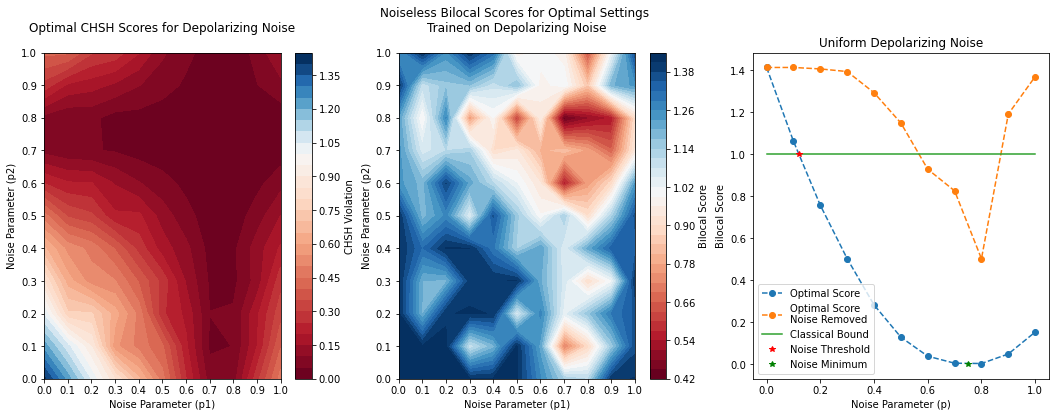

In [13]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

norm_noisy = mcolors.TwoSlopeNorm(vmin=depo_violations.min(), vmax = depo_violations.max(), vcenter=1)
norm_noiseless = mcolors.TwoSlopeNorm(
    vmin=depo_noiseless_violations.min(),
    vmax = depo_noiseless_violations.max(),
    vcenter=1
)

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, depo_violations, 32, cmap="RdBu", norm=norm_noisy)
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("CHSH Violation")
ax1.set_title("Optimal CHSH Scores for Depolarizing Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

plt2 = ax2.contourf(p1_scan_params, p2_scan_params, depo_noiseless_violations, 32, cmap="RdBu", norm=norm_noiseless)
clb2 = plt.colorbar(plt2, ax=ax2)
clb2.set_label("Bilocal Score")
ax2.set_title("Noiseless Bilocal Scores for Optimal Settings \nTrained on Depolarizing Noise\n")
ax2.set_ylabel("Noise Parameter (p2)")
ax2.set_xlabel("Noise Parameter (p1)")
ax2.set_xticks(np.arange(0,1.01,0.1))
ax2.set_yticks(np.arange(0,1.01,0.1))

depo_uniform_scores = [depo_violations[i,i] for i in range(11)]
depo_noiseless_uniform_scores = [depo_noiseless_violations[i,i] for i in range(11)]

plt3 = plt.plot(np.arange(0,1.1,0.1), depo_uniform_scores, "o--", label="Optimal Score")
ax3.plot(np.arange(0,1.1,0.1), depo_noiseless_uniform_scores, "o--", label="Optimal Score\nNoise Removed")
ax3.plot(np.arange(0,1.1,0.1), [1]*11, label="Classical Bound" )
ax3.plot([(1-1/2**(1/4))*3/4], [1], "r*", label="Noise Threshold")
ax3.plot([3/4],[0], "g*", label="Noise Minimum")
ax3.legend(loc="lower left")
ax3.set_title("Uniform Depolarizing Noise")
ax3.set_ylabel("Bilocal Score")
ax3.set_xlabel("Noise Parameter (p)")

plt.show()

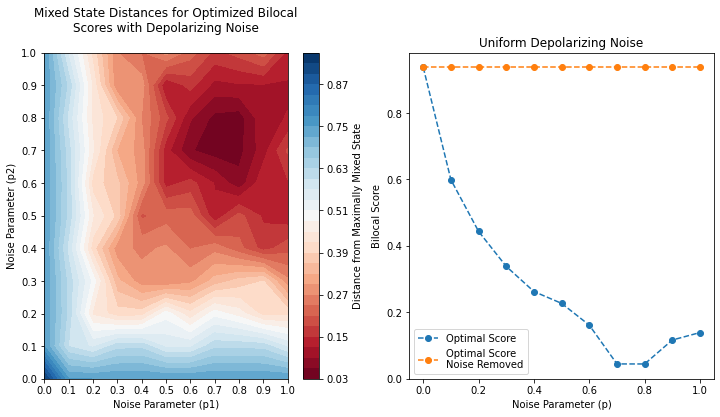

In [19]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, depo_depolarized_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Maximally Mixed State")
ax1.set_title("Mixed State Distances for Optimized Bilocal\nScores with Depolarizing Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

depo_uniform_depolarized_distances = [depo_depolarized_distances[i,i] for i in range(11)]
depo_noiseless_uniform_depolarized_distances = [depo_noiseless_depolarized_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), depo_uniform_depolarized_distances, "o--", label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), depo_noiseless_uniform_depolarized_distances, "o--", label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Depolarizing Noise")
ax2.set_ylabel("Bilocal Score")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

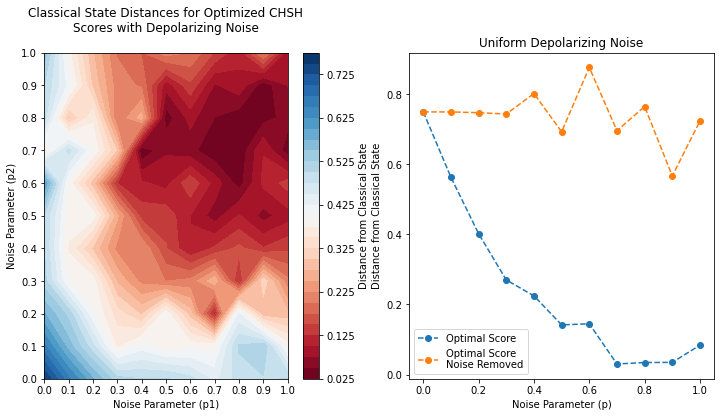

In [20]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, depo_classical_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Classical State")
ax1.set_title("Classical State Distances for Optimized CHSH\nScores with Depolarizing Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

depo_uniform_classical_distances = [depo_classical_distances[i,i] for i in range(11)]
depo_noiseless_uniform_classical_distances = [depo_noiseless_classical_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), depo_uniform_classical_distances, "o--", label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), depo_noiseless_uniform_classical_distances, "o--", label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Depolarizing Noise")
ax2.set_ylabel("Distance from Classical State")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

## Amplitude Damping

In [21]:
%%time

(
    ampdamp_violations,
    ampdamp_noiseless_violations,
    ampdamp_depolarized_distances,
    ampdamp_noiseless_depolarized_distances,
    ampdamp_classical_distances,
    ampdamp_noiseless_classical_distances,
) = scan_channel_robustness(
    bell_prep_nodes,
    RY_meas_nodes,
    [qml.AmplitudeDamping,qml.AmplitudeDamping],
    params_range
)

Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.3499109786216962
elapsed time :  0.27184295654296875
iteration :  5 , score :  1.1730104472435599
elapsed time :  0.2657170295715332
iteration :  10 , score :  1.3206928971330085
elapsed time :  0.24146389961242676
iteration :  15 , score :  1.4076331482433662
elapsed time :  0.2999081611633301
iteration :  20 , score :  1.414101256169387
elapsed time :  0.22885704040527344
iteration :  25 , score :  1.4142120824470337
elapsed time :  0.2328808307647705
iteration :  30 , score :  1.414213543440379
elapsed time :  0.24004507064819336
iteration :  35 , score :  1.4142135621317016
elapsed time :  0.23085618019104004
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.85283808309

elapsed time :  0.2338879108428955
iteration :  5 , score :  1.1354624802834006
elapsed time :  0.23159408569335938
iteration :  10 , score :  1.1796341281477716
elapsed time :  0.23261189460754395
iteration :  15 , score :  1.1877869822916292
elapsed time :  0.23515796661376953
iteration :  20 , score :  1.1889559068125193
elapsed time :  0.23238205909729004
iteration :  25 , score :  1.1891565069271195
elapsed time :  0.2291572093963623
iteration :  30 , score :  1.189195236978088
elapsed time :  0.2294769287109375
iteration :  35 , score :  1.1892029362923389
elapsed time :  0.232374906539917
Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False)]
iteration :  0 , score :  0.5771772665059018
elapsed time :  0.23227596282958984
iteration :  5 , score :  1.136436885723962
elapsed time :  0.23191595077514648
iteration :  10 , score :  1.2570696799451997
elapsed time :  0.228493928909301

iteration :  10 , score :  0.8377907365237725
elapsed time :  0.2282860279083252
iteration :  15 , score :  0.8550549211291797
elapsed time :  0.23142027854919434
iteration :  20 , score :  0.86427729598326
elapsed time :  0.23271393775939941
iteration :  25 , score :  0.8713004238760652
elapsed time :  0.25148487091064453
iteration :  30 , score :  0.878268180966004
elapsed time :  0.24195313453674316
iteration :  35 , score :  0.8862767958992082
elapsed time :  0.23559975624084473
Channel Parameters :  [tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False)]
iteration :  0 , score :  0.4459651392061047
elapsed time :  0.2307600975036621
iteration :  5 , score :  0.9759431291743672
elapsed time :  0.23114895820617676
iteration :  10 , score :  1.0316795210967882
elapsed time :  0.25897884368896484
iteration :  15 , score :  1.08028925397232
elapsed time :  0.2541511058807373
iteration :  20 , score

elapsed time :  0.2284412384033203
iteration :  20 , score :  0.95003445673447
elapsed time :  0.23710012435913086
iteration :  25 , score :  0.9770651574493074
elapsed time :  0.23882699012756348
iteration :  30 , score :  0.9897189746465166
elapsed time :  0.23628902435302734
iteration :  35 , score :  0.9951330348037799
elapsed time :  0.2355499267578125
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0.9, requires_grad=False), tensor(0.2, requires_grad=False), tensor(0.2, requires_grad=False)]
iteration :  0 , score :  0.294568200177067
elapsed time :  0.23518610000610352
iteration :  5 , score :  0.6694544581739283
elapsed time :  0.23709893226623535
iteration :  10 , score :  0.7302132044677587
elapsed time :  0.23640179634094238
iteration :  15 , score :  0.7724307336112861
elapsed time :  0.23514008522033691
iteration :  20 , score :  0.8144416556837906
elapsed time :  0.23656296730041504
iteration :  25 , score :  0.8526820837309141
elapsed time :  0.2351560592

elapsed time :  0.2313241958618164
iteration :  25 , score :  0.912877643218716
elapsed time :  0.23216605186462402
iteration :  30 , score :  0.9225113698102377
elapsed time :  0.23441386222839355
iteration :  35 , score :  0.93199266378575
elapsed time :  0.23700189590454102
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False), tensor(0.3, requires_grad=False), tensor(0.3, requires_grad=False)]
iteration :  0 , score :  0.12732266972326545
elapsed time :  0.235274076461792
iteration :  5 , score :  0.774363858766294
elapsed time :  0.23235678672790527
iteration :  10 , score :  0.8947345637138052
elapsed time :  0.23622393608093262
iteration :  15 , score :  0.93604174989919
elapsed time :  0.2354576587677002
iteration :  20 , score :  0.9586877166624725
elapsed time :  0.23052406311035156
iteration :  25 , score :  0.9729747627714085
elapsed time :  0.2335970401763916
iteration :  30 , score :  0.9826655352112565
elapsed time :  0.225895166397094

iteration :  30 , score :  0.9889710637610589
elapsed time :  0.2379298210144043
iteration :  35 , score :  0.991977729690297
elapsed time :  0.24202799797058105
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.7, requires_grad=False), tensor(0.4, requires_grad=False), tensor(0.4, requires_grad=False)]
iteration :  0 , score :  0.3004381054755786
elapsed time :  0.24273896217346191
iteration :  5 , score :  0.7182480443032693
elapsed time :  0.24657177925109863
iteration :  10 , score :  0.8198713710086956
elapsed time :  0.23829317092895508
iteration :  15 , score :  0.9067597748918095
elapsed time :  0.24567222595214844
iteration :  20 , score :  0.9398861591455847
elapsed time :  0.23282313346862793
iteration :  25 , score :  0.9569460761427654
elapsed time :  0.23498988151550293
iteration :  30 , score :  0.9692509838104866
elapsed time :  0.23582005500793457
iteration :  35 , score :  0.9788207860202462
elapsed time :  0.23703598976135254
Channel Parameters :  [te

elapsed time :  0.22748899459838867
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False), tensor(0.5, requires_grad=False), tensor(0.5, requires_grad=False)]
iteration :  0 , score :  0.35425624283900103
elapsed time :  0.23476815223693848
iteration :  5 , score :  0.7930538630970089
elapsed time :  0.23239493370056152
iteration :  10 , score :  0.9115386496731184
elapsed time :  0.23251581192016602
iteration :  15 , score :  0.9444003708565168
elapsed time :  0.23118281364440918
iteration :  20 , score :  0.9626511775790072
elapsed time :  0.22862482070922852
iteration :  25 , score :  0.9757071047817576
elapsed time :  0.22901391983032227
iteration :  30 , score :  0.984583170491132
elapsed time :  0.2304229736328125
iteration :  35 , score :  0.9901068150518355
elapsed time :  0.2332139015197754
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.7, requires_grad=False), tensor(0.5, requires_grad=False), tensor(0.5, requires_grad=Fa

elapsed time :  0.22580695152282715
iteration :  5 , score :  0.7723669899516863
elapsed time :  0.22960996627807617
iteration :  10 , score :  0.8842802557935954
elapsed time :  0.23280119895935059
iteration :  15 , score :  0.918244131445802
elapsed time :  0.23455309867858887
iteration :  20 , score :  0.9404666046588773
elapsed time :  0.2301349639892578
iteration :  25 , score :  0.9566407981830908
elapsed time :  0.2303919792175293
iteration :  30 , score :  0.9687879473948142
elapsed time :  0.2301630973815918
iteration :  35 , score :  0.9778407147576617
elapsed time :  0.23608994483947754
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False)]
iteration :  0 , score :  0.2976944099386595
elapsed time :  0.23409700393676758
iteration :  5 , score :  0.6089676025758265
elapsed time :  0.23178410530090332
iteration :  10 , score :  0.754650286767359
elapsed time :  0.23024892807

iteration :  10 , score :  0.81102051166627
elapsed time :  0.24376773834228516
iteration :  15 , score :  0.8563924964039139
elapsed time :  0.24705195426940918
iteration :  20 , score :  0.8885955649121368
elapsed time :  0.23246002197265625
iteration :  25 , score :  0.9151695485935062
elapsed time :  0.23098206520080566
iteration :  30 , score :  0.9323384889144671
elapsed time :  0.23072099685668945
iteration :  35 , score :  0.9598914586968943
elapsed time :  0.230971097946167
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0.5, requires_grad=False), tensor(0.7, requires_grad=False), tensor(0.7, requires_grad=False)]
iteration :  0 , score :  0.08615580711340112
elapsed time :  0.22948598861694336
iteration :  5 , score :  0.3989914861769326
elapsed time :  0.23052597045898438
iteration :  10 , score :  0.5433460079929953
elapsed time :  0.22644472122192383
iteration :  15 , score :  0.6043363564712685
elapsed time :  0.230363130569458
iteration :  20 , score :  0

elapsed time :  0.24028301239013672
iteration :  20 , score :  0.8619757788608522
elapsed time :  0.23261594772338867
iteration :  25 , score :  0.8686094978598632
elapsed time :  0.2332320213317871
iteration :  30 , score :  0.8742039117113749
elapsed time :  0.23307275772094727
iteration :  35 , score :  0.8791083157929183
elapsed time :  0.24184584617614746
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0.4, requires_grad=False), tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False)]
iteration :  0 , score :  0.4598424033117616
elapsed time :  0.23559880256652832
iteration :  5 , score :  0.7323744259058089
elapsed time :  0.23294496536254883
iteration :  10 , score :  0.8270947577212235
elapsed time :  0.2348330020904541
iteration :  15 , score :  0.8836658445971586
elapsed time :  0.23502087593078613
iteration :  20 , score :  0.9164695758450356
elapsed time :  0.23460793495178223
iteration :  25 , score :  0.9378686465138188
elapsed time :  0.2347216

elapsed time :  0.2454698085784912
iteration :  25 , score :  0.9951797056864997
elapsed time :  0.24195623397827148
iteration :  30 , score :  1.0056381320475536
elapsed time :  0.2572600841522217
iteration :  35 , score :  1.0130823523307853
elapsed time :  0.2419571876525879
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0.3, requires_grad=False), tensor(0.9, requires_grad=False), tensor(0.9, requires_grad=False)]
iteration :  0 , score :  0.39285136146653454
elapsed time :  0.23653888702392578
iteration :  5 , score :  0.7569534417040044
elapsed time :  0.22638487815856934
iteration :  10 , score :  0.8481596921589895
elapsed time :  0.2283031940460205
iteration :  15 , score :  0.9065511023567893
elapsed time :  0.23087000846862793
iteration :  20 , score :  0.9422507381509366
elapsed time :  0.237138032913208
iteration :  25 , score :  0.960194384816542
elapsed time :  0.24288201332092285
iteration :  30 , score :  0.969776071530546
elapsed time :  0.229503154754

elapsed time :  0.23940801620483398
iteration :  30 , score :  1.097217325039773
elapsed time :  0.24378490447998047
iteration :  35 , score :  1.097304582213257
elapsed time :  0.24506807327270508
Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0.2, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False)]
iteration :  0 , score :  0.32822002274055684
elapsed time :  0.2426588535308838
iteration :  5 , score :  1.007141719557921
elapsed time :  0.2311878204345703
iteration :  10 , score :  1.0384846322637904
elapsed time :  0.2364511489868164
iteration :  15 , score :  1.0415444826918403
elapsed time :  0.24194812774658203
iteration :  20 , score :  1.042998093101076
elapsed time :  0.23398613929748535
iteration :  25 , score :  1.0437443775420356
elapsed time :  0.23272395133972168
iteration :  30 , score :  1.0441295751069106
elapsed time :  0.23471903800964355
iteration :  35 , score :  1.0443293716236166
elapsed time :  0.235

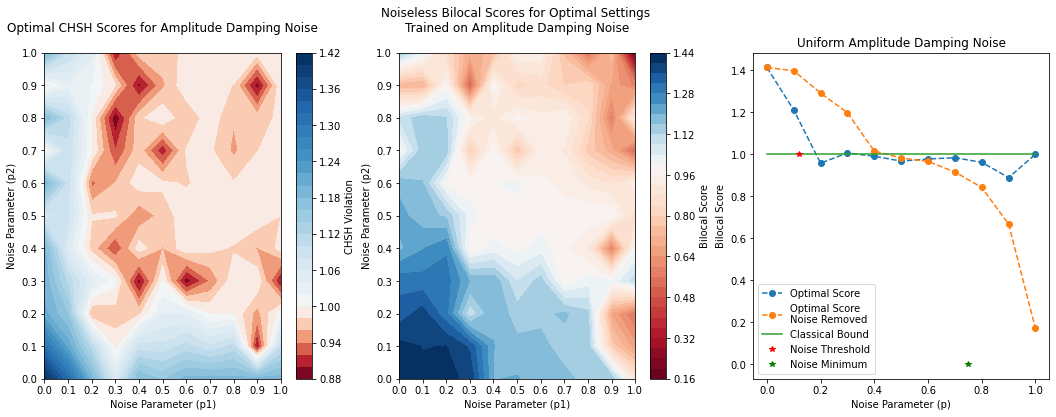

In [24]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

norm_noisy = mcolors.TwoSlopeNorm(vmin=ampdamp_violations.min(), vmax = ampdamp_violations.max(), vcenter=1)
norm_noiseless = mcolors.TwoSlopeNorm(
    vmin=ampdamp_noiseless_violations.min(),
    vmax = ampdamp_noiseless_violations.max(),
    vcenter=1
)

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, ampdamp_violations, 32, cmap="RdBu", norm=norm_noisy)
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("CHSH Violation")
ax1.set_title("Optimal CHSH Scores for Amplitude Damping Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

plt2 = ax2.contourf(p1_scan_params, p2_scan_params, ampdamp_noiseless_violations, 32, cmap="RdBu", norm=norm_noiseless)
clb2 = plt.colorbar(plt2, ax=ax2)
clb2.set_label("Bilocal Score")
ax2.set_title("Noiseless Bilocal Scores for Optimal Settings \nTrained on Amplitude Damping Noise\n")
ax2.set_ylabel("Noise Parameter (p2)")
ax2.set_xlabel("Noise Parameter (p1)")
ax2.set_xticks(np.arange(0,1.01,0.1))
ax2.set_yticks(np.arange(0,1.01,0.1))

ampdamp_uniform_scores = [ampdamp_violations[i,i] for i in range(11)]
ampdamp_noiseless_uniform_scores = [ampdamp_noiseless_violations[i,i] for i in range(11)]

plt3 = plt.plot(np.arange(0,1.1,0.1), ampdamp_uniform_scores, "o--", label="Optimal Score")
ax3.plot(np.arange(0,1.1,0.1), ampdamp_noiseless_uniform_scores, "o--", label="Optimal Score\nNoise Removed")
ax3.plot(np.arange(0,1.1,0.1), [1]*11, label="Classical Bound" )
ax3.plot([(1-1/2**(1/4))*3/4], [1], "r*", label="Noise Threshold")
ax3.plot([3/4],[0], "g*", label="Noise Minimum")
ax3.legend(loc="lower left")
ax3.set_title("Uniform Amplitude Damping Noise")
ax3.set_ylabel("Bilocal Score")
ax3.set_xlabel("Noise Parameter (p)")

plt.show()

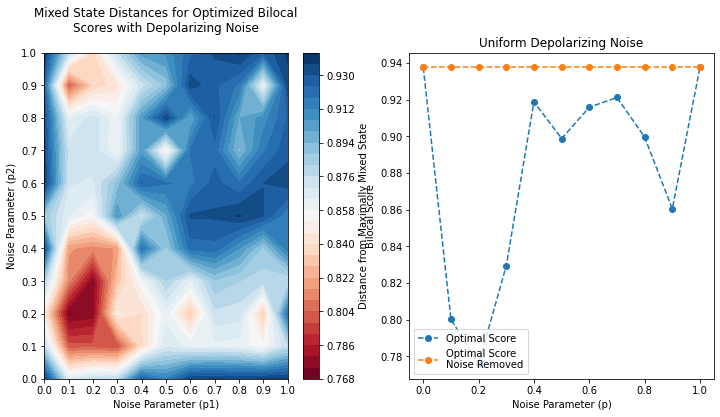

In [23]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, ampdamp_depolarized_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Maximally Mixed State")
ax1.set_title("Mixed State Distances for Optimized Bilocal\nScores with Amplitude Damping Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

ampdamp_uniform_depolarized_distances = [ampdamp_depolarized_distances[i,i] for i in range(11)]
ampdamp_noiseless_uniform_depolarized_distances = [ampdamp_noiseless_depolarized_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), ampdamp_uniform_depolarized_distances, "o--", label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), ampdamp_noiseless_uniform_depolarized_distances, "o--", label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Amplitude Damping Noise")
ax2.set_ylabel("Bilocal Score")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

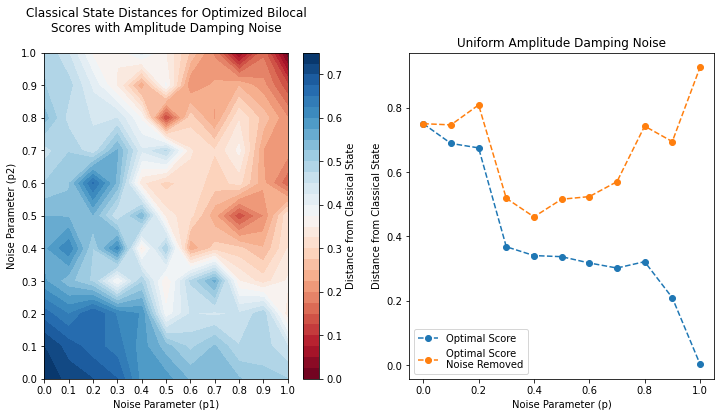

In [25]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, ampdamp_classical_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Classical State")
ax1.set_title("Classical State Distances for Optimized Bilocal\nScores with Amplitude Damping Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

ampdamp_uniform_classical_distances = [ampdamp_classical_distances[i,i] for i in range(11)]
ampdamp_noiseless_uniform_classical_distances = [ampdamp_noiseless_classical_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), ampdamp_uniform_classical_distances, "o--", label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), ampdamp_noiseless_uniform_classical_distances, "o--", label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Amplitude Damping Noise")
ax2.set_ylabel("Distance from Classical State")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

## Phase Damping

In [28]:
%%time

(
    phasedamp_violations,
    phasedamp_noiseless_violations,
    phasedamp_depolarized_distances,
    phasedamp_noiseless_depolarized_distances,
    phasedamp_classical_distances,
    phasedamp_noiseless_classical_distances,
) = scan_channel_robustness(
    bell_prep_nodes,
    RY_meas_nodes,
    [qml.PhaseDamping, qml.PhaseDamping],
    params_range
)

Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.36137722700163943
elapsed time :  0.23888802528381348
iteration :  5 , score :  1.2380672439203286
elapsed time :  0.2591371536254883
iteration :  10 , score :  1.3798316849850374
elapsed time :  0.2312150001525879
iteration :  15 , score :  1.4132743908041727
elapsed time :  0.2396078109741211
iteration :  20 , score :  1.414200360151808
elapsed time :  0.23171424865722656
iteration :  25 , score :  1.4142133922140723
elapsed time :  0.22709298133850098
iteration :  30 , score :  1.4142135602017238
elapsed time :  0.25508785247802734
iteration :  35 , score :  1.414213562345418
elapsed time :  0.24938297271728516
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.2068847446

elapsed time :  0.24010920524597168
iteration :  5 , score :  0.973749950034638
elapsed time :  0.22200798988342285
iteration :  10 , score :  0.999170186414258
elapsed time :  0.23310589790344238
iteration :  15 , score :  1.002016682728529
elapsed time :  0.25804996490478516
iteration :  20 , score :  1.0038156803167084
elapsed time :  0.22583699226379395
iteration :  25 , score :  1.007062806464456
elapsed time :  0.22468209266662598
iteration :  30 , score :  1.0148000180345542
elapsed time :  0.23911285400390625
iteration :  35 , score :  1.03717015672659
elapsed time :  0.2380990982055664
Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False)]
iteration :  0 , score :  0.7974891111741917
elapsed time :  0.23481988906860352
iteration :  5 , score :  1.3502700229804767
elapsed time :  0.23166799545288086
iteration :  10 , score :  1.3786105008744234
elapsed time :  0.255427122116088

iteration :  10 , score :  0.9438064505590932
elapsed time :  0.24034523963928223
iteration :  15 , score :  0.9840417250666549
elapsed time :  0.2411510944366455
iteration :  20 , score :  1.037509093389593
elapsed time :  0.23550915718078613
iteration :  25 , score :  1.1229126518170984
elapsed time :  0.22841691970825195
iteration :  30 , score :  1.156632349813726
elapsed time :  0.22912812232971191
iteration :  35 , score :  1.1601428766590485
elapsed time :  0.23095226287841797
Channel Parameters :  [tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False)]
iteration :  0 , score :  0.5734308398975939
elapsed time :  0.22512483596801758
iteration :  5 , score :  1.088980929770325
elapsed time :  0.26796483993530273
iteration :  10 , score :  1.138861145076643
elapsed time :  0.22822976112365723
iteration :  15 , score :  1.1557973177820808
elapsed time :  0.22820019721984863
iteration :  20 , sc

elapsed time :  0.27454161643981934
iteration :  20 , score :  1.1286746773305532
elapsed time :  0.2858150005340576
iteration :  25 , score :  1.1371472420774982
elapsed time :  0.289578914642334
iteration :  30 , score :  1.139491178200264
elapsed time :  0.29819798469543457
iteration :  35 , score :  1.140349000764581
elapsed time :  0.23956704139709473
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0.9, requires_grad=False), tensor(0.2, requires_grad=False), tensor(0.2, requires_grad=False)]
iteration :  0 , score :  0.3820087796240111
elapsed time :  0.28441810607910156
iteration :  5 , score :  1.0938302172951766
elapsed time :  0.30390429496765137
iteration :  10 , score :  1.1287441905489153
elapsed time :  0.24080324172973633
iteration :  15 , score :  1.1322459627592123
elapsed time :  0.24665474891662598
iteration :  20 , score :  1.1327648462272233
elapsed time :  0.24425315856933594
iteration :  25 , score :  1.1328941435962478
elapsed time :  0.2456171512

iteration :  25 , score :  1.1209627656556156
elapsed time :  0.25980305671691895
iteration :  30 , score :  1.1231617668128395
elapsed time :  0.24574899673461914
iteration :  35 , score :  1.1249153023818725
elapsed time :  0.2474210262298584
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False), tensor(0.3, requires_grad=False), tensor(0.3, requires_grad=False)]
iteration :  0 , score :  0.45229734564975027
elapsed time :  0.2542388439178467
iteration :  5 , score :  1.0414060960496978
elapsed time :  0.2412869930267334
iteration :  10 , score :  1.0916061342521857
elapsed time :  0.2503669261932373
iteration :  15 , score :  1.1085885100916653
elapsed time :  0.28694581985473633
iteration :  20 , score :  1.113504789358717
elapsed time :  0.2572948932647705
iteration :  25 , score :  1.114772376087799
elapsed time :  0.26848387718200684
iteration :  30 , score :  1.1151421557232113
elapsed time :  0.24140381813049316
iteration :  35 , score :  1.

elapsed time :  0.26157093048095703
iteration :  35 , score :  1.006615269287225
elapsed time :  0.24328899383544922
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.7, requires_grad=False), tensor(0.4, requires_grad=False), tensor(0.4, requires_grad=False)]
iteration :  0 , score :  0.40197013037169094
elapsed time :  0.243499755859375
iteration :  5 , score :  1.012828678550865
elapsed time :  0.24879169464111328
iteration :  10 , score :  1.0736103868042157
elapsed time :  0.25816893577575684
iteration :  15 , score :  1.0852169042074633
elapsed time :  0.2660970687866211
iteration :  20 , score :  1.0898032713310455
elapsed time :  0.24124503135681152
iteration :  25 , score :  1.0928233910622536
elapsed time :  0.33251404762268066
iteration :  30 , score :  1.0953817007684936
elapsed time :  0.23532629013061523
iteration :  35 , score :  1.0975678566088614
elapsed time :  0.23495697975158691
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0.8, requ

Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False), tensor(0.5, requires_grad=False), tensor(0.5, requires_grad=False)]
iteration :  0 , score :  0.28160056647498494
elapsed time :  0.2588951587677002
iteration :  5 , score :  0.6118133787515705
elapsed time :  0.2480757236480713
iteration :  10 , score :  0.7381786593828502
elapsed time :  0.25875186920166016
iteration :  15 , score :  0.8634762667935285
elapsed time :  0.3541381359100342
iteration :  20 , score :  0.9597635812927073
elapsed time :  0.24090194702148438
iteration :  25 , score :  1.0165403646939744
elapsed time :  0.2400341033935547
iteration :  30 , score :  1.0490583239872526
elapsed time :  0.2476201057434082
iteration :  35 , score :  1.0684258518514502
elapsed time :  0.23353123664855957
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.7, requires_grad=False), tensor(0.5, requires_grad=False), tensor(0.5, requires_grad=False)]
iteration :  0 , score :  0.5684

elapsed time :  0.27799296379089355
iteration :  5 , score :  0.9573657785591578
elapsed time :  0.26517415046691895
iteration :  10 , score :  0.9989211238911286
elapsed time :  0.29990172386169434
iteration :  15 , score :  1.0194535106082236
elapsed time :  0.27413296699523926
iteration :  20 , score :  1.0342381689987852
elapsed time :  0.2937500476837158
iteration :  25 , score :  1.0479803840229198
elapsed time :  0.2915778160095215
iteration :  30 , score :  1.062093017729592
elapsed time :  0.2735562324523926
iteration :  35 , score :  1.0752068737630132
elapsed time :  0.27004289627075195
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False)]
iteration :  0 , score :  0.25806129173421727
elapsed time :  0.2849128246307373
iteration :  5 , score :  0.8903604785331165
elapsed time :  0.2953810691833496
iteration :  10 , score :  0.9771584108476096
elapsed time :  0.28543186187

iteration :  10 , score :  1.0684200091536853
elapsed time :  0.24977421760559082
iteration :  15 , score :  1.0832364625217337
elapsed time :  0.2818450927734375
iteration :  20 , score :  1.088912017715164
elapsed time :  0.24050688743591309
iteration :  25 , score :  1.0924137636899047
elapsed time :  0.26689934730529785
iteration :  30 , score :  1.0951193511212731
elapsed time :  0.24052691459655762
iteration :  35 , score :  1.0973461786577416
elapsed time :  0.24700093269348145
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0.5, requires_grad=False), tensor(0.7, requires_grad=False), tensor(0.7, requires_grad=False)]
iteration :  0 , score :  0.3438863319200465
elapsed time :  0.2557389736175537
iteration :  5 , score :  1.0314600457806988
elapsed time :  0.2767510414123535
iteration :  10 , score :  1.0536603935132318
elapsed time :  0.3179891109466553
iteration :  15 , score :  1.0567676767937102
elapsed time :  0.2846648693084717
iteration :  20 , score :  1.

elapsed time :  0.3461270332336426
iteration :  20 , score :  1.1148918441276203
elapsed time :  0.33882617950439453
iteration :  25 , score :  1.1155167302537716
elapsed time :  0.4024240970611572
iteration :  30 , score :  1.1156568078094717
elapsed time :  0.39661502838134766
iteration :  35 , score :  1.1156937443233408
elapsed time :  0.2443687915802002
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0.4, requires_grad=False), tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False)]
iteration :  0 , score :  0.5857789312716979
elapsed time :  0.23643922805786133
iteration :  5 , score :  0.9691784444872286
elapsed time :  0.22980713844299316
iteration :  10 , score :  1.046646451503599
elapsed time :  0.24307823181152344
iteration :  15 , score :  1.0755725341111249
elapsed time :  0.23549389839172363
iteration :  20 , score :  1.0862773039135736
elapsed time :  0.23957610130310059
iteration :  25 , score :  1.0894883891296703
elapsed time :  0.237101078

iteration :  25 , score :  1.131424883919124
elapsed time :  0.25098395347595215
iteration :  30 , score :  1.1318884225043968
elapsed time :  0.23741912841796875
iteration :  35 , score :  1.1319914083611753
elapsed time :  0.2365281581878662
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0.3, requires_grad=False), tensor(0.9, requires_grad=False), tensor(0.9, requires_grad=False)]
iteration :  0 , score :  0.16030899562376152
elapsed time :  0.2387678623199463
iteration :  5 , score :  0.8891961306821637
elapsed time :  0.23121881484985352
iteration :  10 , score :  1.0004774912443222
elapsed time :  0.23906302452087402
iteration :  15 , score :  1.0192669140590822
elapsed time :  0.23724889755249023
iteration :  20 , score :  1.0276332486591864
elapsed time :  0.23981308937072754
iteration :  25 , score :  1.0357185492811876
elapsed time :  0.2462172508239746
iteration :  30 , score :  1.0471038160077648
elapsed time :  0.23405218124389648
iteration :  35 , score : 

elapsed time :  0.23840904235839844
iteration :  35 , score :  1.1598959954458206
elapsed time :  0.23711895942687988
Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0.2, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False)]
iteration :  0 , score :  0.16622525377008363
elapsed time :  0.23911762237548828
iteration :  5 , score :  1.071358232959889
elapsed time :  0.24630975723266602
iteration :  10 , score :  1.12334270765056
elapsed time :  0.24816203117370605
iteration :  15 , score :  1.1303404111114896
elapsed time :  0.2338848114013672
iteration :  20 , score :  1.131409072863132
elapsed time :  0.23877525329589844
iteration :  25 , score :  1.1316003393198693
elapsed time :  0.2456068992614746
iteration :  30 , score :  1.1316376383590785
elapsed time :  0.24132084846496582
iteration :  35 , score :  1.1316450884024087
elapsed time :  0.235306978225708
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0.3,

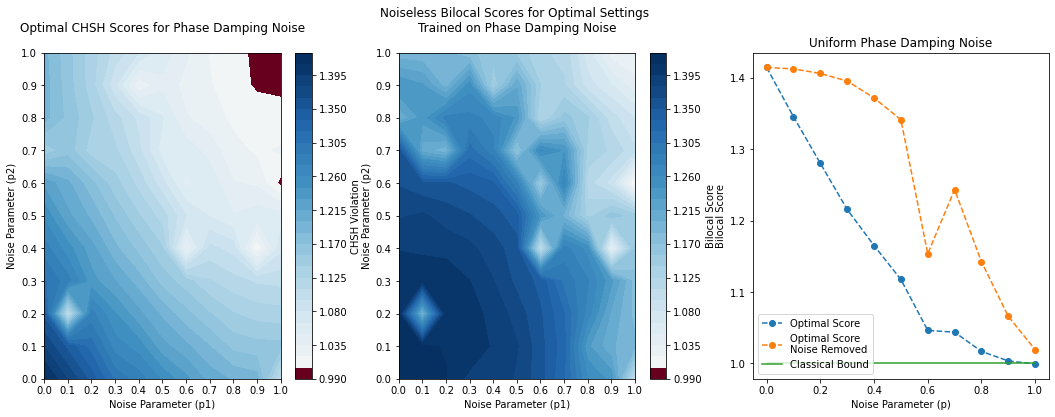

In [30]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

norm_noisy = mcolors.TwoSlopeNorm(vmin=phasedamp_violations.min(), vmax = phasedamp_violations.max(), vcenter=1)
norm_noiseless = mcolors.TwoSlopeNorm(
    vmin=phasedamp_noiseless_violations.min(),
    vmax = phasedamp_noiseless_violations.max(),
    vcenter=1
)

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, phasedamp_violations, 32, cmap="RdBu", norm=norm_noisy)
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("CHSH Violation")
ax1.set_title("Optimal CHSH Scores for Phase Damping Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

plt2 = ax2.contourf(p1_scan_params, p2_scan_params, phasedamp_noiseless_violations, 32, cmap="RdBu", norm=norm_noiseless)
clb2 = plt.colorbar(plt2, ax=ax2)
clb2.set_label("Bilocal Score")
ax2.set_title("Noiseless Bilocal Scores for Optimal Settings \nTrained on Phase Damping Noise\n")
ax2.set_ylabel("Noise Parameter (p2)")
ax2.set_xlabel("Noise Parameter (p1)")
ax2.set_xticks(np.arange(0,1.01,0.1))
ax2.set_yticks(np.arange(0,1.01,0.1))

phasedamp_uniform_scores = [phasedamp_violations[i,i] for i in range(11)]
phasedamp_noiseless_uniform_scores = [phasedamp_noiseless_violations[i,i] for i in range(11)]

plt3 = plt.plot(np.arange(0,1.1,0.1), phasedamp_uniform_scores, "o--", label="Optimal Score")
ax3.plot(np.arange(0,1.1,0.1), phasedamp_noiseless_uniform_scores, "o--", label="Optimal Score\nNoise Removed")
ax3.plot(np.arange(0,1.1,0.1), [1]*11, label="Classical Bound" )
ax3.legend(loc="lower left")
ax3.set_title("Uniform Phase Damping Noise")
ax3.set_ylabel("Bilocal Score")
ax3.set_xlabel("Noise Parameter (p)")

plt.show()

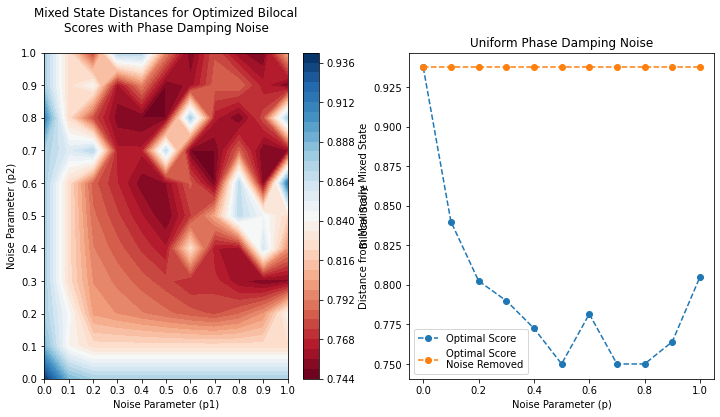

In [31]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, phasedamp_depolarized_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Maximally Mixed State")
ax1.set_title("Mixed State Distances for Optimized Bilocal\nScores with Phase Damping Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

phasedamp_uniform_depolarized_distances = [phasedamp_depolarized_distances[i,i] for i in range(11)]
phasedamp_noiseless_uniform_depolarized_distances = [phasedamp_noiseless_depolarized_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), phasedamp_uniform_depolarized_distances, "o--", label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), phasedamp_noiseless_uniform_depolarized_distances, "o--", label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Phase Damping Noise")
ax2.set_ylabel("Bilocal Score")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

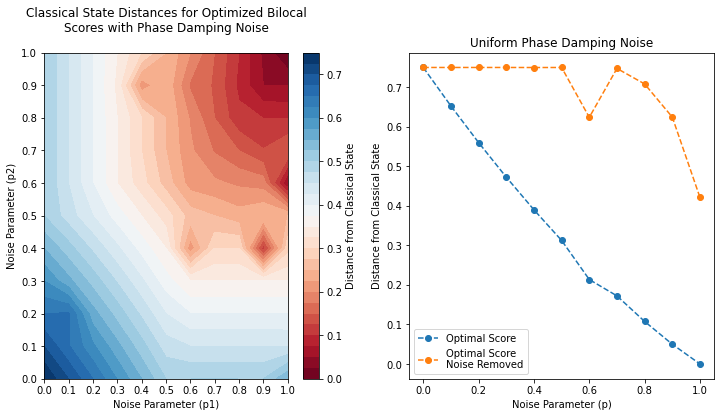

In [33]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, phasedamp_classical_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Classical State")
ax1.set_title("Classical State Distances for Optimized Bilocal\nScores with Phase Damping Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

phasedamp_uniform_classical_distances = [phasedamp_classical_distances[i,i] for i in range(11)]
phasedamp_noiseless_uniform_classical_distances = [phasedamp_noiseless_classical_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), phasedamp_uniform_classical_distances, "o--", label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), phasedamp_noiseless_uniform_classical_distances, "o--", label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Phase Damping Noise")
ax2.set_ylabel("Distance from Classical State")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

## Bit Flip

In [34]:
%%time

(
    bitflip_violations,
    bitflip_noiseless_violations,
    bitflip_depolarized_distances,
    bitflip_noiseless_depolarized_distances,
    bitflip_classical_distances,
    bitflip_noiseless_classical_distances,
) = scan_channel_robustness(
    bell_prep_nodes,
    RY_meas_nodes,
    [qml.BitFlip, qml.BitFlip],
    params_range
)

Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.6742642234517853
elapsed time :  0.28521180152893066
iteration :  5 , score :  1.1646557562958768
elapsed time :  0.2705528736114502
iteration :  10 , score :  1.2202097958183356
elapsed time :  0.28406524658203125
iteration :  15 , score :  1.3179825447225335
elapsed time :  0.24013495445251465
iteration :  20 , score :  1.4067775187526073
elapsed time :  0.3012120723724365
iteration :  25 , score :  1.4140836176043914
elapsed time :  0.2349529266357422
iteration :  30 , score :  1.4142118450923071
elapsed time :  0.25992298126220703
iteration :  35 , score :  1.4142135403967067
elapsed time :  0.25120997428894043
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.510965149

elapsed time :  0.2597050666809082
iteration :  5 , score :  1.3014904581133628
elapsed time :  0.23519420623779297
iteration :  10 , score :  1.4073523227460072
elapsed time :  0.23704075813293457
iteration :  15 , score :  1.414083743525403
elapsed time :  0.2505059242248535
iteration :  20 , score :  1.414197894749831
elapsed time :  0.23261094093322754
iteration :  25 , score :  1.414199400928044
elapsed time :  0.23546719551086426
iteration :  30 , score :  1.4141994202006376
elapsed time :  0.23657989501953125
iteration :  35 , score :  1.4141994204463821
elapsed time :  0.23725080490112305
Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False)]
iteration :  0 , score :  0.5886634222672242
elapsed time :  0.24266290664672852
iteration :  5 , score :  1.240283295844625
elapsed time :  0.23219990730285645
iteration :  10 , score :  1.2915242810767977
elapsed time :  0.23509097099304

iteration :  10 , score :  0.9933495309561533
elapsed time :  0.23393702507019043
iteration :  15 , score :  1.0317733647498366
elapsed time :  0.24117708206176758
iteration :  20 , score :  1.0613070823638369
elapsed time :  0.23378896713256836
iteration :  25 , score :  1.0884763822371988
elapsed time :  0.2841930389404297
iteration :  30 , score :  1.1224676735948933
elapsed time :  0.23830580711364746
iteration :  35 , score :  1.1594068623152447
elapsed time :  0.2799830436706543
Channel Parameters :  [tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False)]
iteration :  0 , score :  0.45986006139037183
elapsed time :  0.2973198890686035
iteration :  5 , score :  1.151799308946559
elapsed time :  0.28340768814086914
iteration :  10 , score :  1.2736031218829282
elapsed time :  0.26952600479125977
iteration :  15 , score :  1.2827972961328522
elapsed time :  0.2637028694152832
iteration :  20 , s

elapsed time :  0.24239802360534668
iteration :  20 , score :  1.028330227811093
elapsed time :  0.24373984336853027
iteration :  25 , score :  1.0329241244116147
elapsed time :  0.24499893188476562
iteration :  30 , score :  1.0372856544704638
elapsed time :  0.24261903762817383
iteration :  35 , score :  1.0418436713904284
elapsed time :  0.24320483207702637
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0.9, requires_grad=False), tensor(0.2, requires_grad=False), tensor(0.2, requires_grad=False)]
iteration :  0 , score :  0.22008546158484696
elapsed time :  0.24129199981689453
iteration :  5 , score :  0.9572686766238399
elapsed time :  0.24376416206359863
iteration :  10 , score :  0.9929401901037149
elapsed time :  0.24111390113830566
iteration :  15 , score :  1.002341004617767
elapsed time :  0.2473299503326416
iteration :  20 , score :  1.0105503245569485
elapsed time :  0.24188995361328125
iteration :  25 , score :  1.0269738139206577
elapsed time :  0.2440900

iteration :  25 , score :  1.0101620624070875
elapsed time :  0.2415940761566162
iteration :  30 , score :  1.010376185101093
elapsed time :  0.2405078411102295
iteration :  35 , score :  1.0105744468838116
elapsed time :  0.24604010581970215
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False), tensor(0.3, requires_grad=False), tensor(0.3, requires_grad=False)]
iteration :  0 , score :  0.5973600510223034
elapsed time :  0.30560731887817383
iteration :  5 , score :  0.9794991629362076
elapsed time :  0.24990224838256836
iteration :  10 , score :  1.0157011642798737
elapsed time :  0.2539839744567871
iteration :  15 , score :  1.0250619398367609
elapsed time :  0.2501819133758545
iteration :  20 , score :  1.0296492899302094
elapsed time :  0.24268317222595215
iteration :  25 , score :  1.032572075907586
elapsed time :  0.2503390312194824
iteration :  30 , score :  1.0345017231019984
elapsed time :  0.25249481201171875
iteration :  35 , score :  1.0

elapsed time :  0.2582740783691406
iteration :  35 , score :  1.000083820968331
elapsed time :  0.30029797554016113
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.7, requires_grad=False), tensor(0.4, requires_grad=False), tensor(0.4, requires_grad=False)]
iteration :  0 , score :  0.06478129403461418
elapsed time :  0.24232697486877441
iteration :  5 , score :  0.7755938449890872
elapsed time :  0.23874115943908691
iteration :  10 , score :  0.9751605821236046
elapsed time :  0.24202394485473633
iteration :  15 , score :  0.9973990228132826
elapsed time :  0.24237990379333496
iteration :  20 , score :  1.002238744833317
elapsed time :  0.32041120529174805
iteration :  25 , score :  1.0036685408940238
elapsed time :  0.3087592124938965
iteration :  30 , score :  1.0041849425008937
elapsed time :  0.2946341037750244
iteration :  35 , score :  1.0044518632304416
elapsed time :  0.3055579662322998
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0.8, requi

Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False), tensor(0.5, requires_grad=False), tensor(0.5, requires_grad=False)]
iteration :  0 , score :  0.38341762030551696
elapsed time :  0.2411661148071289
iteration :  5 , score :  0.9542165108938929
elapsed time :  0.24214887619018555
iteration :  10 , score :  0.9904502001553581
elapsed time :  0.23975396156311035
iteration :  15 , score :  0.9972576859313654
elapsed time :  0.2447359561920166
iteration :  20 , score :  0.9992203095180447
elapsed time :  0.24231386184692383
iteration :  25 , score :  0.9998345428955393
elapsed time :  0.24002575874328613
iteration :  30 , score :  1.0000311487723896
elapsed time :  0.24096894264221191
iteration :  35 , score :  1.000094690170142
elapsed time :  0.24106478691101074
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.7, requires_grad=False), tensor(0.5, requires_grad=False), tensor(0.5, requires_grad=False)]
iteration :  0 , score :  0.41

elapsed time :  0.24217700958251953
iteration :  5 , score :  0.8057759212351118
elapsed time :  0.24010181427001953
iteration :  10 , score :  0.9788455472905442
elapsed time :  0.23934173583984375
iteration :  15 , score :  0.9945750714104646
elapsed time :  0.240645170211792
iteration :  20 , score :  0.9983193337750158
elapsed time :  0.23939085006713867
iteration :  25 , score :  0.9994617963767946
elapsed time :  0.2395949363708496
iteration :  30 , score :  0.999834669490973
elapsed time :  0.24121689796447754
iteration :  35 , score :  0.9999598480457241
elapsed time :  0.24136805534362793
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False)]
iteration :  0 , score :  0.1719466492454693
elapsed time :  0.24010610580444336
iteration :  5 , score :  0.9399238875931247
elapsed time :  0.24253296852111816
iteration :  10 , score :  0.9897346101357898
elapsed time :  0.2388508319

iteration :  10 , score :  0.997782755338745
elapsed time :  0.27230191230773926
iteration :  15 , score :  0.9989008327590635
elapsed time :  0.24213409423828125
iteration :  20 , score :  0.9994135778034924
elapsed time :  0.24203109741210938
iteration :  25 , score :  0.9996884481018393
elapsed time :  0.23978877067565918
iteration :  30 , score :  0.9998408677049866
elapsed time :  0.2555360794067383
iteration :  35 , score :  0.9999273557058138
elapsed time :  0.24109983444213867
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0.5, requires_grad=False), tensor(0.7, requires_grad=False), tensor(0.7, requires_grad=False)]
iteration :  0 , score :  0.3125715868900084
elapsed time :  0.2414851188659668
iteration :  5 , score :  0.9256664290754566
elapsed time :  0.23963522911071777
iteration :  10 , score :  0.9921727340667017
elapsed time :  0.2415480613708496
iteration :  15 , score :  1.0001196734984037
elapsed time :  0.24001812934875488
iteration :  20 , score :  

elapsed time :  0.2570838928222656
iteration :  20 , score :  1.0149560885718276
elapsed time :  0.2504861354827881
iteration :  25 , score :  1.0199365629138326
elapsed time :  0.26072120666503906
iteration :  30 , score :  1.0244271459280774
elapsed time :  0.24006390571594238
iteration :  35 , score :  1.028433192202816
elapsed time :  0.2633662223815918
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0.4, requires_grad=False), tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False)]
iteration :  0 , score :  0.4578750011079212
elapsed time :  0.2512691020965576
iteration :  5 , score :  0.9375364201357893
elapsed time :  0.2646200656890869
iteration :  10 , score :  0.9816700468095916
elapsed time :  0.2622201442718506
iteration :  15 , score :  0.9953560378308088
elapsed time :  0.2617342472076416
iteration :  20 , score :  0.999261944197936
elapsed time :  0.290377140045166
iteration :  25 , score :  1.0004738226955716
elapsed time :  0.2724540233612060

iteration :  25 , score :  1.0924871096851223
elapsed time :  0.2479400634765625
iteration :  30 , score :  1.1094165574328712
elapsed time :  0.309783935546875
iteration :  35 , score :  1.11769433943561
elapsed time :  0.28450894355773926
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0.3, requires_grad=False), tensor(0.9, requires_grad=False), tensor(0.9, requires_grad=False)]
iteration :  0 , score :  0.34771697338726065
elapsed time :  0.24975299835205078
iteration :  5 , score :  0.9490501654584481
elapsed time :  0.2817728519439697
iteration :  10 , score :  1.0521884542666193
elapsed time :  0.2866511344909668
iteration :  15 , score :  1.0853089823306536
elapsed time :  0.2729508876800537
iteration :  20 , score :  1.0938650834621666
elapsed time :  0.27442502975463867
iteration :  25 , score :  1.0955226261643858
elapsed time :  0.30355215072631836
iteration :  30 , score :  1.0958762578341437
elapsed time :  0.26172900199890137
iteration :  35 , score :  1.0

elapsed time :  0.2449331283569336
iteration :  35 , score :  1.2872228832077512
elapsed time :  0.24298882484436035
Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0.2, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False)]
iteration :  0 , score :  0.3847100942118566
elapsed time :  0.24803400039672852
iteration :  5 , score :  0.7243150838491448
elapsed time :  0.24456191062927246
iteration :  10 , score :  0.9340799546756288
elapsed time :  0.2439570426940918
iteration :  15 , score :  1.1013640206829916
elapsed time :  0.2441558837890625
iteration :  20 , score :  1.1783238304894954
elapsed time :  0.2572300434112549
iteration :  25 , score :  1.2068407324181436
elapsed time :  0.24279093742370605
iteration :  30 , score :  1.2179682941591583
elapsed time :  0.24610280990600586
iteration :  35 , score :  1.2226662578568392
elapsed time :  0.24320411682128906
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0

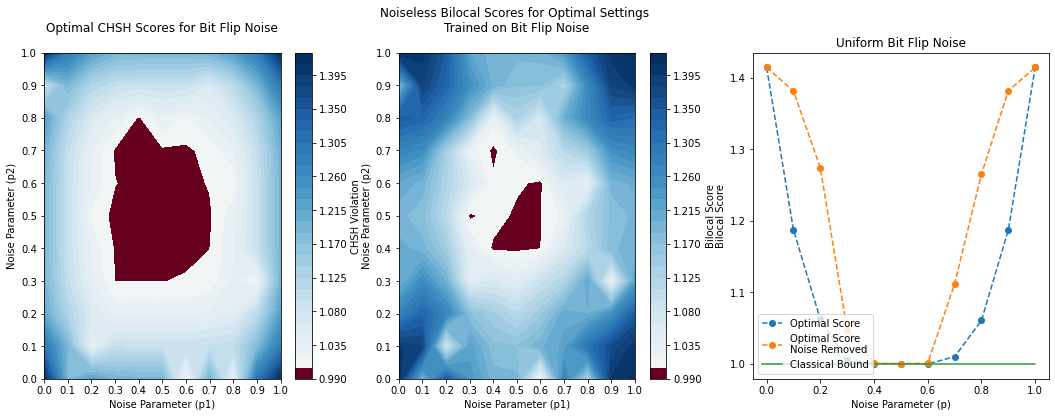

In [54]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

norm_noisy = mcolors.TwoSlopeNorm(vmin=bitflip_violations.min(), vmax = bitflip_violations.max(), vcenter=1.0001)
norm_noiseless = mcolors.TwoSlopeNorm(
    vmin=bitflip_noiseless_violations.min(),
    vmax = bitflip_noiseless_violations.max(),
    vcenter=1.0001
)

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, bitflip_violations, 32, cmap="RdBu", norm=norm_noisy)
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("CHSH Violation")
ax1.set_title("Optimal CHSH Scores for Bit Flip Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

plt2 = ax2.contourf(p1_scan_params, p2_scan_params, bitflip_noiseless_violations, 32, cmap="RdBu", norm=norm_noiseless)
clb2 = plt.colorbar(plt2, ax=ax2)
clb2.set_label("Bilocal Score")
ax2.set_title("Noiseless Bilocal Scores for Optimal Settings \nTrained on Bit Flip Noise\n")
ax2.set_ylabel("Noise Parameter (p2)")
ax2.set_xlabel("Noise Parameter (p1)")
ax2.set_xticks(np.arange(0,1.01,0.1))
ax2.set_yticks(np.arange(0,1.01,0.1))

bitflip_uniform_scores = [bitflip_violations[i,i] for i in range(11)]
bitflip_noiseless_uniform_scores = [bitflip_noiseless_violations[i,i] for i in range(11)]

plt3 = plt.plot(np.arange(0,1.1,0.1), bitflip_uniform_scores, "o--", label="Optimal Score")
ax3.plot(np.arange(0,1.1,0.1), bitflip_noiseless_uniform_scores, "o--", label="Optimal Score\nNoise Removed")
ax3.plot(np.arange(0,1.1,0.1), [1]*11, label="Classical Bound" )
ax3.legend(loc="lower left")
ax3.set_title("Uniform Bit Flip Noise")
ax3.set_ylabel("Bilocal Score")
ax3.set_xlabel("Noise Parameter (p)")

plt.show()

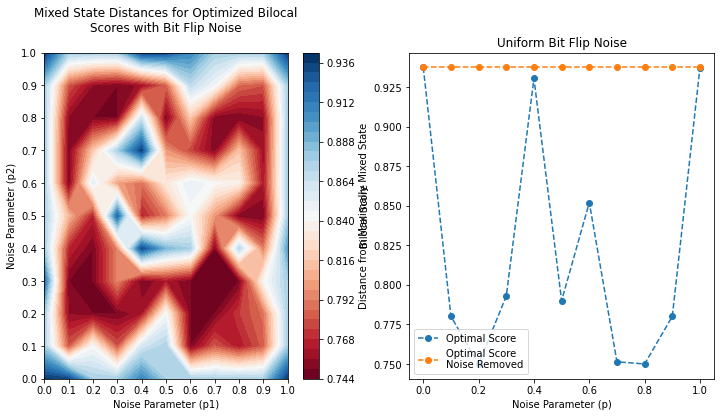

In [50]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, bitflip_depolarized_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Maximally Mixed State")
ax1.set_title("Mixed State Distances for Optimized Bilocal\nScores with Bit Flip Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

bitflip_uniform_depolarized_distances = [bitflip_depolarized_distances[i,i] for i in range(11)]
bitflip_noiseless_uniform_depolarized_distances = [bitflip_noiseless_depolarized_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), bitflip_uniform_depolarized_distances, "o--", label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), bitflip_noiseless_uniform_depolarized_distances, "o--", label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Bit Flip Noise")
ax2.set_ylabel("Bilocal Score")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

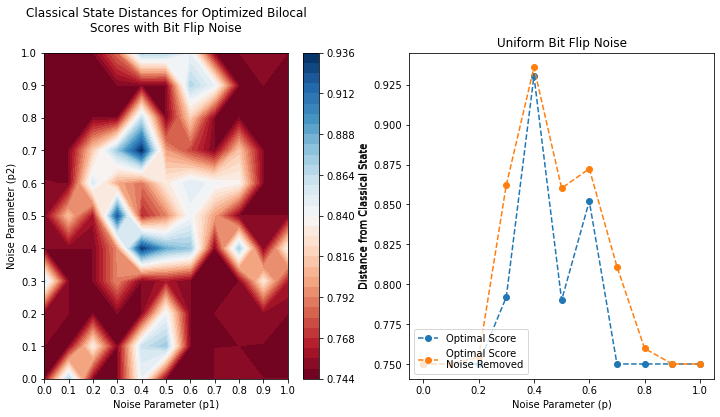

In [49]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, bitflip_classical_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Classical State")
ax1.set_title("Classical State Distances for Optimized Bilocal\nScores with Bit Flip Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

bitflip_uniform_classical_distances = [bitflip_classical_distances[i,i] for i in range(11)]
bitflip_noiseless_uniform_classical_distances = [bitflip_noiseless_classical_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), bitflip_uniform_classical_distances, "o--", label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), bitflip_noiseless_uniform_classical_distances, "o--", label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Bit Flip Noise")
ax2.set_ylabel("Distance from Classical State")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

## Phase Flip

In [52]:
%%time

(
    phaseflip_violations,
    phaseflip_noiseless_violations,
    phaseflip_depolarized_distances,
    phaseflip_noiseless_depolarized_distances,
    phaseflip_classical_distances,
    phaseflip_noiseless_classical_distances
) = scan_channel_robustness(
    bell_prep_nodes,
    RY_meas_nodes,
    [qml.PhaseFlip, qml.PhaseFlip],
    params_range
)

Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.3391690373322941
elapsed time :  0.3140749931335449
iteration :  5 , score :  1.1093770122166786
elapsed time :  0.33339691162109375
iteration :  10 , score :  1.2618977901452413
elapsed time :  0.30443501472473145
iteration :  15 , score :  1.395549843327795
elapsed time :  0.24872493743896484
iteration :  20 , score :  1.413815529780282
elapsed time :  0.24123191833496094
iteration :  25 , score :  1.4142081580950814
elapsed time :  0.24170994758605957
iteration :  30 , score :  1.4142134929981154
elapsed time :  0.24603486061096191
iteration :  35 , score :  1.414213561488215
elapsed time :  0.23903203010559082
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.3531835163

elapsed time :  0.24082112312316895
iteration :  5 , score :  1.0295667715731431
elapsed time :  0.24123072624206543
iteration :  10 , score :  1.0907205246611014
elapsed time :  0.2405078411102295
iteration :  15 , score :  1.16905884013344
elapsed time :  0.24037599563598633
iteration :  20 , score :  1.1881985279391625
elapsed time :  0.2407848834991455
iteration :  25 , score :  1.189273108033293
elapsed time :  0.24156785011291504
iteration :  30 , score :  1.189354637422677
elapsed time :  0.24103903770446777
iteration :  35 , score :  1.189419520782229
elapsed time :  0.2517280578613281
Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False)]
iteration :  0 , score :  0.1839412988323556
elapsed time :  0.24193191528320312
iteration :  5 , score :  1.0527653628510527
elapsed time :  0.24017977714538574
iteration :  10 , score :  1.159743063003838
elapsed time :  0.24046802520751953

iteration :  10 , score :  0.9260050388388947
elapsed time :  0.24698996543884277
iteration :  15 , score :  1.0309649643135521
elapsed time :  0.2615339756011963
iteration :  20 , score :  1.129379692062306
elapsed time :  0.2570219039916992
iteration :  25 , score :  1.173787334850664
elapsed time :  0.2763938903808594
iteration :  30 , score :  1.1845677146164808
elapsed time :  0.2578132152557373
iteration :  35 , score :  1.1865609256696623
elapsed time :  0.251589298248291
Channel Parameters :  [tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False)]
iteration :  0 , score :  0.5235998461396731
elapsed time :  0.2508878707885742
iteration :  5 , score :  1.1409853807939774
elapsed time :  0.2468111515045166
iteration :  10 , score :  1.268396832788251
elapsed time :  0.25763416290283203
iteration :  15 , score :  1.286995218900652
elapsed time :  0.2528798580169678
iteration :  20 , score :  1

iteration :  20 , score :  1.0578574993296856
elapsed time :  0.25269198417663574
iteration :  25 , score :  1.059879058517619
elapsed time :  0.24439382553100586
iteration :  30 , score :  1.061108681582859
elapsed time :  0.24599599838256836
iteration :  35 , score :  1.061836453482396
elapsed time :  0.2865469455718994
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0.9, requires_grad=False), tensor(0.2, requires_grad=False), tensor(0.2, requires_grad=False)]
iteration :  0 , score :  0.1439959345695557
elapsed time :  0.2446887493133545
iteration :  5 , score :  0.8268238943276578
elapsed time :  0.2801070213317871
iteration :  10 , score :  1.0389697424944524
elapsed time :  0.3273289203643799
iteration :  15 , score :  1.1111259562501303
elapsed time :  0.2897968292236328
iteration :  20 , score :  1.120033698143173
elapsed time :  0.2529416084289551
iteration :  25 , score :  1.121964866261267
elapsed time :  0.29117703437805176
iteration :  30 , score :  1.12269

elapsed time :  0.24099493026733398
iteration :  30 , score :  1.0066980313218872
elapsed time :  0.23999810218811035
iteration :  35 , score :  1.006761229734186
elapsed time :  0.24063611030578613
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False), tensor(0.3, requires_grad=False), tensor(0.3, requires_grad=False)]
iteration :  0 , score :  0.2421461474297638
elapsed time :  0.237807035446167
iteration :  5 , score :  0.9739417062003212
elapsed time :  0.24080109596252441
iteration :  10 , score :  1.0074215942916647
elapsed time :  0.24067401885986328
iteration :  15 , score :  1.0127294151797255
elapsed time :  0.23940396308898926
iteration :  20 , score :  1.0170748447530622
elapsed time :  0.24158191680908203
iteration :  25 , score :  1.0211568804320357
elapsed time :  0.24012374877929688
iteration :  30 , score :  1.024552548126548
elapsed time :  0.23969292640686035
iteration :  35 , score :  1.0270381353783182
elapsed time :  0.240526199

iteration :  35 , score :  1.0006626953839588
elapsed time :  0.3071129322052002
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.7, requires_grad=False), tensor(0.4, requires_grad=False), tensor(0.4, requires_grad=False)]
iteration :  0 , score :  0.2806729940549428
elapsed time :  0.2948307991027832
iteration :  5 , score :  0.9718987728234286
elapsed time :  0.2820620536804199
iteration :  10 , score :  1.0047303607435647
elapsed time :  0.28780078887939453
iteration :  15 , score :  1.0062383390089589
elapsed time :  0.2541160583496094
iteration :  20 , score :  1.0063332684082318
elapsed time :  0.24437403678894043
iteration :  25 , score :  1.0063447982206033
elapsed time :  0.2569608688354492
iteration :  30 , score :  1.0063506252896084
elapsed time :  0.2808849811553955
iteration :  35 , score :  1.0063555423151664
elapsed time :  0.25130224227905273
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False), tensor(0.4, requires

elapsed time :  0.23969197273254395
iteration :  5 , score :  0.6457051383174826
elapsed time :  0.24460887908935547
iteration :  10 , score :  0.9861423865159232
elapsed time :  0.2539680004119873
iteration :  15 , score :  0.9993955769754181
elapsed time :  0.25429201126098633
iteration :  20 , score :  1.000295343753903
elapsed time :  0.28211307525634766
iteration :  25 , score :  1.000387005267416
elapsed time :  0.2463679313659668
iteration :  30 , score :  1.0003975704107593
elapsed time :  0.250809907913208
iteration :  35 , score :  1.000398830005762
elapsed time :  0.2388761043548584
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.7, requires_grad=False), tensor(0.5, requires_grad=False), tensor(0.5, requires_grad=False)]
iteration :  0 , score :  0.4389546713757175
elapsed time :  0.248093843460083
iteration :  5 , score :  0.9580038348859887
elapsed time :  0.23942089080810547
iteration :  10 , score :  0.987396196364318
elapsed time :  0.26369285583496094

iteration :  10 , score :  0.9894049691511413
elapsed time :  0.24287199974060059
iteration :  15 , score :  0.9952035457379746
elapsed time :  0.24634289741516113
iteration :  20 , score :  0.99739954286008
elapsed time :  0.26870203018188477
iteration :  25 , score :  0.9984596634729425
elapsed time :  0.28044891357421875
iteration :  30 , score :  0.9990462131898536
elapsed time :  0.2452528476715088
iteration :  35 , score :  0.9994011363524774
elapsed time :  0.24604487419128418
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False), tensor(0.6, requires_grad=False)]
iteration :  0 , score :  0.05539346285681963
elapsed time :  0.2739429473876953
iteration :  5 , score :  0.8740031661618721
elapsed time :  0.2688100337982178
iteration :  10 , score :  0.9927316916877442
elapsed time :  0.24425506591796875
iteration :  15 , score :  0.9995794382011879
elapsed time :  0.24547314643859863
iteration :  20 , score :  

elapsed time :  0.2476639747619629
iteration :  20 , score :  1.000231743079119
elapsed time :  0.24625921249389648
iteration :  25 , score :  1.0006475069843832
elapsed time :  0.246992826461792
iteration :  30 , score :  1.0008120433565113
elapsed time :  0.2496941089630127
iteration :  35 , score :  1.0009173475829958
elapsed time :  0.2456798553466797
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0.5, requires_grad=False), tensor(0.7, requires_grad=False), tensor(0.7, requires_grad=False)]
iteration :  0 , score :  0.027534734211669423
elapsed time :  0.24715399742126465
iteration :  5 , score :  0.9279075112550657
elapsed time :  0.2454221248626709
iteration :  10 , score :  0.9975369035079964
elapsed time :  0.264570951461792
iteration :  15 , score :  1.000639845146581
elapsed time :  0.24602389335632324
iteration :  20 , score :  1.000887053820843
elapsed time :  0.24344110488891602
iteration :  25 , score :  1.0009934577440514
elapsed time :  0.24305701255798

iteration :  25 , score :  1.0322432348182495
elapsed time :  0.23160290718078613
iteration :  30 , score :  1.0327989219125333
elapsed time :  0.23258495330810547
iteration :  35 , score :  1.03310819903708
elapsed time :  0.22779607772827148
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0.4, requires_grad=False), tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False)]
iteration :  0 , score :  0.6319050177165366
elapsed time :  0.23641705513000488
iteration :  5 , score :  1.015998589603897
elapsed time :  0.22817301750183105
iteration :  10 , score :  1.029287456852403
elapsed time :  0.2259519100189209
iteration :  15 , score :  1.0307200543146484
elapsed time :  0.2267298698425293
iteration :  20 , score :  1.0309418087892441
elapsed time :  0.22898411750793457
iteration :  25 , score :  1.030994732940627
elapsed time :  0.2290489673614502
iteration :  30 , score :  1.0310153435206992
elapsed time :  0.23081493377685547
iteration :  35 , score :  1.03

elapsed time :  0.23744511604309082
iteration :  35 , score :  1.1208410060488359
elapsed time :  0.22977590560913086
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0.3, requires_grad=False), tensor(0.9, requires_grad=False), tensor(0.9, requires_grad=False)]
iteration :  0 , score :  0.3021887421226904
elapsed time :  0.22860097885131836
iteration :  5 , score :  0.8256634241540333
elapsed time :  0.2296450138092041
iteration :  10 , score :  1.0341806408606464
elapsed time :  0.23368406295776367
iteration :  15 , score :  1.089023577160712
elapsed time :  0.22790193557739258
iteration :  20 , score :  1.0943310574728913
elapsed time :  0.23065519332885742
iteration :  25 , score :  1.095125423194352
elapsed time :  0.22846722602844238
iteration :  30 , score :  1.095372936764838
elapsed time :  0.2292768955230713
iteration :  35 , score :  1.0955175419484036
elapsed time :  0.22916507720947266
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0.4, requi

elapsed time :  0.22798681259155273
Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0.2, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False)]
iteration :  0 , score :  0.1823429426711806
elapsed time :  0.22748970985412598
iteration :  5 , score :  1.1484031942183015
elapsed time :  0.22799015045166016
iteration :  10 , score :  1.196387786858236
elapsed time :  0.22910690307617188
iteration :  15 , score :  1.2119843589028743
elapsed time :  0.23163104057312012
iteration :  20 , score :  1.2198354626903316
elapsed time :  0.2265620231628418
iteration :  25 , score :  1.2234438405077488
elapsed time :  0.22940897941589355
iteration :  30 , score :  1.2249631764509452
elapsed time :  0.2308201789855957
iteration :  35 , score :  1.225576624631388
elapsed time :  0.22771573066711426
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0.3, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, re

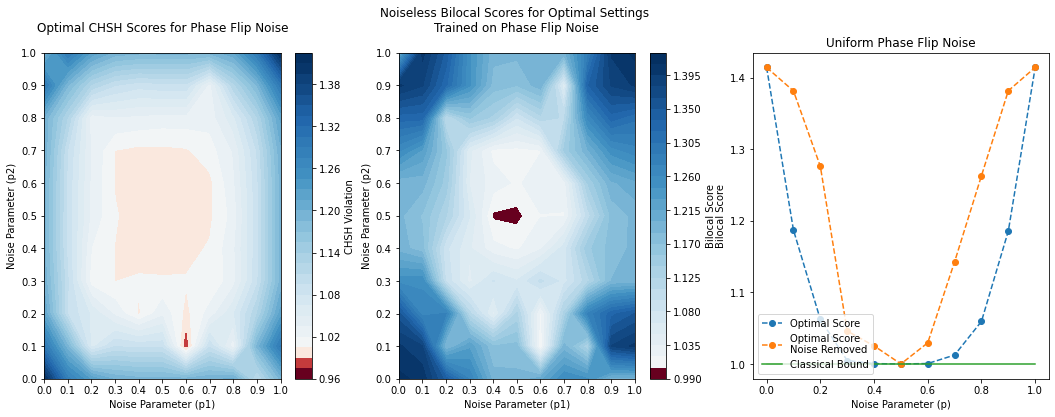

In [53]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

norm_noisy = mcolors.TwoSlopeNorm(vmin=phaseflip_violations.min(), vmax = phaseflip_violations.max(), vcenter=1.0001)
norm_noiseless = mcolors.TwoSlopeNorm(
    vmin=phaseflip_noiseless_violations.min(),
    vmax = phaseflip_noiseless_violations.max(),
    vcenter=1.0001
)

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, phaseflip_violations, 32, cmap="RdBu", norm=norm_noisy)
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("CHSH Violation")
ax1.set_title("Optimal CHSH Scores for Phase Flip Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

plt2 = ax2.contourf(p1_scan_params, p2_scan_params, phaseflip_noiseless_violations, 32, cmap="RdBu", norm=norm_noiseless)
clb2 = plt.colorbar(plt2, ax=ax2)
clb2.set_label("Bilocal Score")
ax2.set_title("Noiseless Bilocal Scores for Optimal Settings \nTrained on Phase Flip Noise\n")
ax2.set_ylabel("Noise Parameter (p2)")
ax2.set_xlabel("Noise Parameter (p1)")
ax2.set_xticks(np.arange(0,1.01,0.1))
ax2.set_yticks(np.arange(0,1.01,0.1))

phaseflip_uniform_scores = [phaseflip_violations[i,i] for i in range(11)]
phaseflip_noiseless_uniform_scores = [phaseflip_noiseless_violations[i,i] for i in range(11)]

plt3 = plt.plot(np.arange(0,1.1,0.1), phaseflip_uniform_scores, "o--", label="Optimal Score")
ax3.plot(np.arange(0,1.1,0.1), phaseflip_noiseless_uniform_scores, "o--", label="Optimal Score\nNoise Removed")
ax3.plot(np.arange(0,1.1,0.1), [1]*11, label="Classical Bound" )
ax3.legend(loc="lower left")
ax3.set_title("Uniform Phase Flip Noise")
ax3.set_ylabel("Bilocal Score")
ax3.set_xlabel("Noise Parameter (p)")

plt.show()

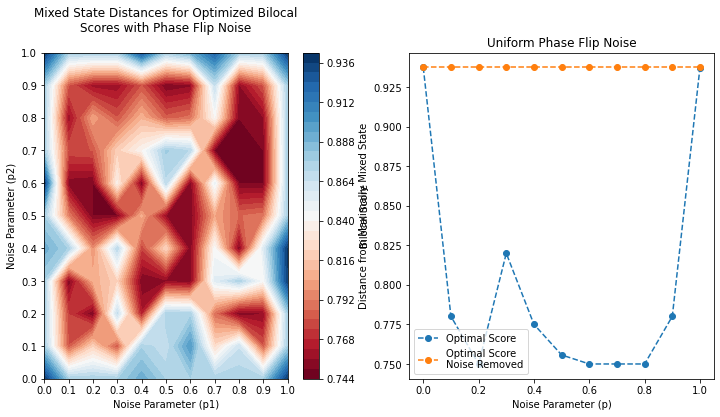

In [55]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, phaseflip_depolarized_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Maximally Mixed State")
ax1.set_title("Mixed State Distances for Optimized Bilocal\nScores with Phase Flip Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

phaseflip_uniform_depolarized_distances = [phaseflip_depolarized_distances[i,i] for i in range(11)]
phaseflip_noiseless_uniform_depolarized_distances = [phaseflip_noiseless_depolarized_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), phaseflip_uniform_depolarized_distances, "o--", label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), phaseflip_noiseless_uniform_depolarized_distances, "o--", label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Phase Flip Noise")
ax2.set_ylabel("Bilocal Score")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

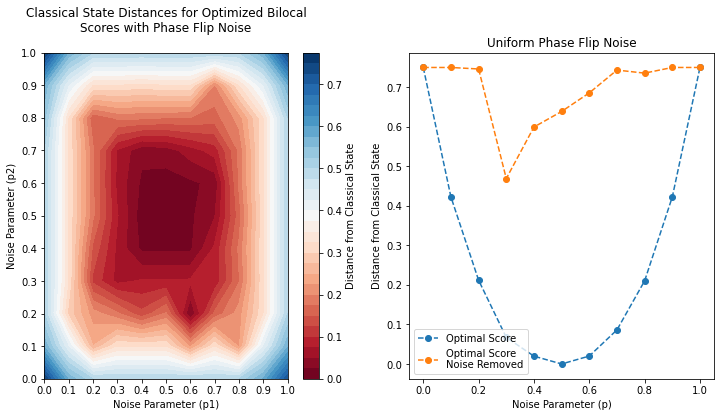

In [56]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, phaseflip_classical_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Classical State")
ax1.set_title("Classical State Distances for Optimized Bilocal\nScores with Phase Flip Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

phaseflip_uniform_classical_distances = [phaseflip_classical_distances[i,i] for i in range(11)]
phaseflip_noiseless_uniform_classical_distances = [phaseflip_noiseless_classical_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), phaseflip_uniform_classical_distances, "o--", label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), phaseflip_noiseless_uniform_classical_distances, "o--", label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Phase Flip Noise")
ax2.set_ylabel("Distance from Classical State")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()